<a href="https://colab.research.google.com/github/WyvernCore/Deep-RL/blob/main/NAF_(Deep_Q_for_continuous_action_spaces).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DQN for continuous action spaces: Normalized Advantage Function (NAF)

In [ ]:
!apt-get install -y xvfb

!pip install \
    gym==0.21 \
    gym[box2d] \
    pytorch-lightning==1.6.0 \
    pyvirtualdisplay

#### Setup virtual display

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [8]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [4]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

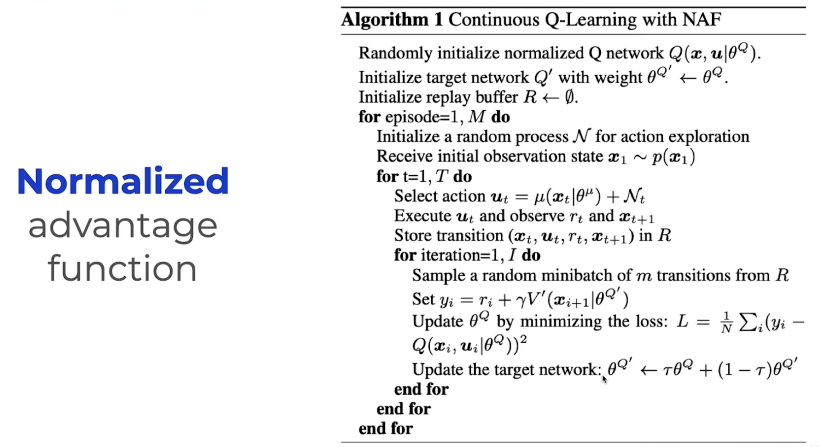

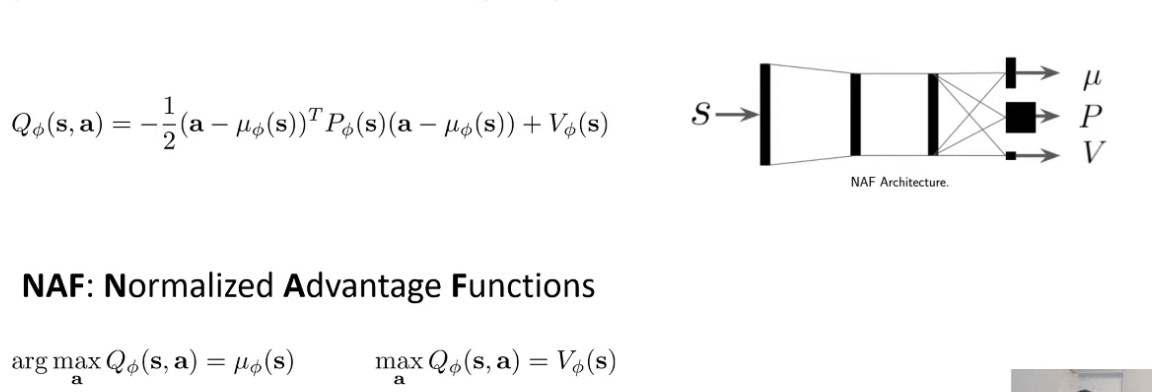

#### Create the Deep Q-Network

In [5]:
class NafDQN(nn.Module):

  def __init__(self, hidden_size, obs_size, action_dims, max_action): 
    super().__init__()
    self.action_dims = action_dims
    self.max_action = torch.from_numpy(max_action).to(device) #send to GPU or CPU
    self.net = nn.Sequential
    (
        nn.Linear(obs_size, hidden_size), #Input Layer
        nn.Relu(), #ReLu activation function
        nn.Linear(hidden_size, hidden_size), #hidden Layer
        nn.Relu(), #ReLu activation function
    )

    self.linear_mu = nn.Linear(hidden_size, action_dims) #array of values (action dimensions)
    self.linear_value = nn.Linear(hidden_size, 1) #value -> 1
    self.linear_matrix = nn.Linear(hidden_size, int(action_dims * (action_dims + 1) / 2)) #number entries in lower traingle of matrix multiplied with themselves for P value
    #positive definate and efficient

  # Compute Mu -> compute the action with the highest Q-Value
    @torch.no_grad() #train in foward pass not here
    def mu(self, x):
      x = self.net(x)
      x = self.linear_mu(x)
      x = torch.tanh(x) * self.max_action #[-inf, inf] --> [-1, 1] mapping with hyperbolic tangent (max action scales to range)
      return x

  # Value -> compute the expected return starting from that state
    @torch.no_grad() #train in foward pass not here
    def value(self, x):
      x = self.net(x)
      x = self.linear_value(x)
      return x

  # Foward -> compute the Q-Value (according to value and state)
    def forward(self, x, a):
      x = self.net(x)
      mu = torch.tanh(self.linear_mu(x)) * self.max_action #Mu from aboce
      value = self.linear_value(x) #V from above

      # P(x)
      matrix = torch.tanh(self.linear_matrix(x)) # [...] vector of values

      L = torch.zeros(x.shape[0], self.action_dims, self.action_dims) #lower triangular matrix filled with zeros | batch-size x action_dims x action_dims
      tril_indices = torch.tril_indices(row=self.action_dims, col=self.action_dims).to(device)
      L[:, tril_indices[0], tril_indices[1]] = matrix
      L.diagonal(dim1=1, dim2=2).exp_() #make sure its posivite definate / batch of matrices
      P = L * L.transpose(2, 1) #transpose 2 n 1

      u_mu = (a-mu).unsqueeze(dim=1) #difference between a and mu
      u_mu_t = u_mu.transpose(1,2)

      adv = - 1 / 2 * u_mu @ P @ u_mu_t 
      adv = adv.squeeze(dim=1)
      return value + adv #complete the Q(S,A) values as shown above


#### Create the policy

In [7]:
def noisy_policy(state, env, net, epsilon=0.0):
  state = torch.tensor([state]).to(device) #Pass a batch of observations | device -> CPU or GPU
  amin = torch.from_numpy(env.action_space.low).to(device) #get min
  amax = torch.from_numpy(env.action_space.high).to(device) #get max

  mu = net.mu(state)
  mu = mu + torch.noraml(0, epsilon, mu.size(), device=device) #Normalise to explore surroundings of the actions selected (Exploration)
  action = mu.clamp(amin, amax) #clamp the mu value between the lower and upper bound
  action = action.squeeze().cpu().numpy() #remove any extra dimension created, push these on the cpu and turn them into numpy
  return action

#### Create the replay buffer

In [9]:
class ReplayBuffer: #Store enviroment observations (kinda like a database) | Stored as [State, Action, Reward, Next State] 
  def __init__(self, capacity): #defining the capacity of the replay buffer
    self.buffer = deque(maxlen=capacity) #Using a queue data structure

  def __len__(self):  #return the length of the buffer
    return len(self.buffer)
  
  def append(self, experience): #save experience in the database
    self.buffer.append(experience)
  
  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size) #get a sample of explisit buffer size

In [10]:
class RLDataset(IterableDataset): #class to allow pytorch to select a sample from buffer one at a time (the batch)
  def __init__(self, buffer, sample_size=200): #go through each element one at a time
    self.buffer = buffer
    self.sample_size = sample_size
  
  def __iter__(self): #take a sample from buffer and return elements one at a time
    for exp in self.buffer.sample(self.sample_size):
      yield exp

#### Create the environment

In [11]:
class RepeatActionWrapper(gym.Wrapper):
  def __init__(self, env, n): #n -> number of times
      super().__init__(env)
      self.env = env
      self.n = n
  
  def step(self, action):
      done = False
      total_reward = 0.0

      for _ in range(self.n):
        next_state, reward, done, info = self.env.step(action)
        total_reward += reward
        if done:
          break
      
      return next_state, total_reward, done, info

In [12]:
def create_environment(name): #Using gym to easily create an enviroment and pass the name of it
  env = gym.make(name)
  env = TimeLimit(env, max_episode_steps=400)
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x%50 == 0) #record every fifty episodes
  env = RepeatActionWrapper(env, n=8) #make actions more consistant with continues actions
  env = RecordEpisodeStatistics(env) #Keep history of rewards from the env
  return env

#### Update the target network

#### Create the Deep Q-Learning algorithm

#### Purge logs and run the visualization tool (Tensorboard)

#### Train the policy

#### Check the resulting policy